In [1]:
import os
import sys
sys.path.append("../python/")
from helpers import *
#import pickle
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as tkr
from itertools import combinations
from scipy.stats import ttest_ind, f_oneway # for independent t-test

In [2]:
SENSITIVITY_RESULTS_DIR = '../../results/sensitivity-tests-05312022' #'../../results/sensitivity-tests-02272021'
SCENARIO_LIST = ["Pr_Im", "PrPo_Im", "Pr_PoIm", "Pr_Po_Im"]
IMAGE_WIDTH_LIST = [336] #189, 252,
TM = time.strftime('%d-%b-%Y-%H-%M-%S')

In [3]:
def getPerformanceDataFrame():
    result_file_list = getListOfFiles(SENSITIVITY_RESULTS_DIR)
    df = pd.DataFrame()
    for filename in result_file_list:
        if "scenario-resolution-" in filename:
            performance_dict = json.load(open(filename))
            performance_df = pd.DataFrame(performance_dict["metrics"])
            performance_df['epoch'] = performance_df.index + 1
            performance_df["width"] = performance_dict["image_width"]
            performance_df["height"] = performance_dict["image_height"]
            performance_df["scenario"] = performance_dict["scenario"]
            #performance_df["best_val_accuracy"] = performance_dict["best_val_accuracy"]
            performance_df["trial"] = int(filename.split("-")[-1].split(".")[0])
            df = df.append(performance_df, ignore_index=True)    
    return(df)

In [4]:
def getScenarioResolutionMeanPerformance(objective="val_accuracy"):
    dp = getPerformanceDataFrame()
    #print(dp.head())
    #dpagg = dp.groupby(['scenario','width', 'height','trial','epoch']).agg('max')
    df = dp.loc[dp.groupby(['scenario','width', 'height', 'trial'])[objective].idxmax()]
    print(df.head())
    df = df.iloc[:,[3, 4, 5, 6, 8, 10]]  #val_accuracy 	val_f1 	val_recall 	val_precision scenario
    df = df.groupby(['scenario','width']).agg(['mean','std'])
    df = np.round(df, 2)
    df = df.reindex(index=["Pr_Im", "PrPo_Im", "Pr_PoIm", "Pr_Po_Im"], level=0)
    df.to_csv('../../results/scenario-resolution-best-mean-std-performance-obj-' + objective + '.csv')    
    return df

In [5]:
getScenarioResolutionMeanPerformance('val_f1')

        loss  accuracy  val_loss  val_accuracy    val_f1  val_recall  \
18  0.046198  0.994516  0.796363      0.656934  0.640841    0.639805   
34  0.033849  1.000000  0.711317      0.631387  0.618158    0.618333   
51  0.103626  0.987203  0.659158      0.624088  0.623962    0.643813   
69  0.184512  0.965297  0.647309      0.684982  0.662129    0.659342   
98  0.023752  1.000000  0.985594      0.611722  0.586836    0.586336   

    val_precision  epoch  width  height scenario  trial  
18       0.642547     19    336     336  PrPo_Im      1  
34       0.618000     15    336     336  PrPo_Im      2  
51       0.641969     12    336     336  PrPo_Im      3  
69       0.671571     10    336     336  PrPo_Im      4  
98       0.591810     19    336     336  PrPo_Im      5  


val_accuracy       val_f1       val_recall       val_precision  \
                       mean   std   mean   std       mean   std          mean   
scenario width                                                                  
Pr_Im    336           0.74  0.05   0.64  0.05       0.65  0.04          0.65   
PrPo_Im  336           0.64  0.03   0.63  0.03       0.63  0.03          0.63   
Pr_PoIm  336           0.77  0.02   0.61  0.04       0.61  0.05          0.61   
Pr_Po_Im 336           0.54  0.03   0.45  0.01       0.45  0.01          0.46   

                      
                 std  
scenario width        
Pr_Im    336    0.05  
PrPo_Im  336    0.03  
Pr_PoIm  336    0.03  
Pr_Po_Im 336    0.02

### FIGURE 4

In [184]:
def plotMeanAccuracyLoss():
    df = getPerformanceDataFrame()
    #df = df[df.epoch <16]
    melted_df = df.melt(id_vars = ["epoch", "width", "scenario", "trial"], value_vars = ["loss", "accuracy", "val_loss", "val_accuracy"], var_name = "metric", value_name = "value")
    melted_df["type"] = None
    melted_df.loc[melted_df.metric.isin(["loss", "val_loss"]), "type"] = "Loss"
    melted_df.loc[melted_df.metric.isin(["accuracy", "val_accuracy"]), "type"] = "Accuracy"
    print(melted_df.head())
    num_scenarios = len(df.scenario.unique())
    num_resolutions = len(df.width.unique())
    num_epochs = df.epoch.max()
    sns.set_style("whitegrid")
    g = sns.FacetGrid(melted_df, col="scenario", row="type", sharey = False, col_order= ["Pr_Im", "PrPo_Im", "Pr_PoIm", "Pr_Po_Im"])
    g.map_dataframe(sns.lineplot, x = "epoch", y = "value", style = "metric",# style_order = ['Validation','Training'], 
                    hue = "width",# estimator=None, units='trial',
                    palette= sns.color_palette("Set1", n_colors=num_resolutions),
                   alpha=1)
    g.set_axis_labels("Epoch", "",  fontsize=14)
    g.add_legend( fontsize=16) 
    ## Customize legend
    g._legend.texts[0].set_text("Resolution") #,prop={'weight':'bold'})
    g._legend.texts[num_resolutions + 1].set_text("Phase") #, prop={'weight':'bold'}) #Data
    g._legend.texts[num_resolutions + 2].set_text("Training")
    g._legend.texts[num_resolutions + 3].set_text("Validation")    
    g._legend.texts[num_resolutions + 4].set_text("")    
    g._legend.texts[num_resolutions + 5].set_text("")    
    g._legend.legendHandles[num_resolutions + 4].set_linewidth(0)
    g._legend.legendHandles[num_resolutions + 5].set_linewidth(0)    
    g._legend._legend_box.sep = 5
    axes = g.axes
    for row, axlist in enumerate(axes):
        if row==0:
            for col, axis in enumerate(axes[row]):
                axes[row, col].set_ylim(0, 5)#.75 
                axes[row, col].set_xlim(1, num_epochs)
                axes[row, col].xaxis.set_major_locator(tkr.AutoLocator())
                axes[row, col].set_title("Scenario: " + 
                                         str(axes[row, col].title).split("scenario = ")[1].split(")")[0].split("\'")[0], fontsize=16)
                if col != 0:
                    axes[row, col].get_yaxis().set_ticklabels([])
                else:
                    axes[row, col].set_ylabel("Loss", fontsize=14)
        elif row==1:
            for col, axis in enumerate(axes[row]):
                axes[row, col].set_ylim(0, 1)
                axes[row, col].set_xlim(1, num_epochs)
                axes[row, col].set_title("")
                if col != 0:
                    axes[row, col].get_yaxis().set_ticklabels([])
                else:
                    axes[row, col].set_ylabel("Accuracy", fontsize=14)
    g.savefig("../../figures/scenario_resolution_performance_336.png", dpi=180)
    return(g)

   epoch  width scenario  trial metric     value  type
0      1    336  PrPo_Im      1   loss  0.702654  Loss
1      2    336  PrPo_Im      1   loss  0.643292  Loss
2      3    336  PrPo_Im      1   loss  0.592274  Loss
3      4    336  PrPo_Im      1   loss  0.547064  Loss
4      5    336  PrPo_Im      1   loss  0.496663  Loss


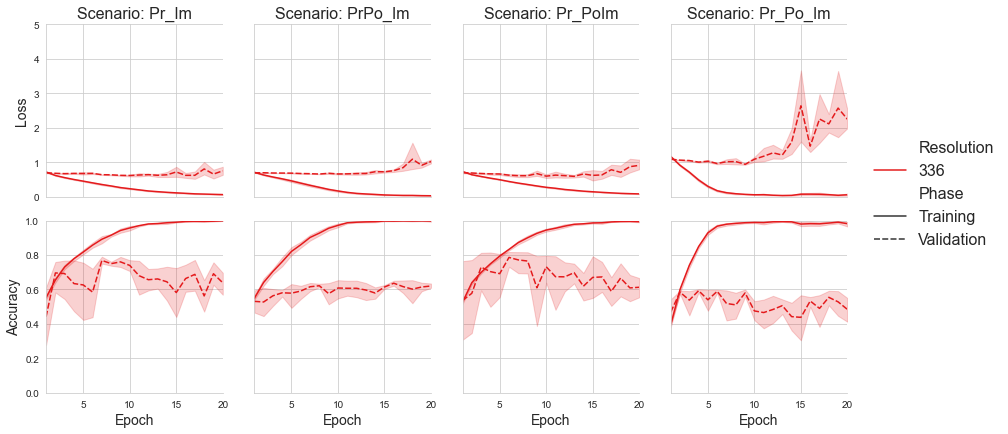

In [16]:
gg = plotMeanAccuracyLoss()

### FIGURE 5 

In [65]:
def plotMeanValidationMetric(metric="val_f1"):
    df = getPerformanceDataFrame()
    #df = df[df.epoch <16]
    melted_df = df.melt(id_vars = ["epoch", "width", "scenario", "trial"], value_vars = [metric], var_name = "metric", value_name = "value")
    melted_df["type"] = None
    num_scenarios = len(df.scenario.unique())
    num_resolutions = len(df.width.unique())
    num_epochs = df.epoch.max()
    sns.set_style("whitegrid")
    g = sns.FacetGrid(melted_df, col="scenario", sharey = True, col_order= ["Pr_Im", "PrPo_Im", "Pr_PoIm", "Pr_Po_Im"])
    g.map_dataframe(sns.lineplot, x = "epoch", y = "value", style = "metric",# style_order = ['Validation','Training'], 
                    hue = "width",# estimator=None, units='trial',
                    palette= sns.color_palette("Set1", n_colors=num_resolutions),
                   alpha=1)
    g.set_axis_labels("Epoch", "",  fontsize=14)
    g.add_legend( fontsize=16, bbox_to_anchor=(1.05, .5)) 
    ## Customize legend
    g._legend.texts[0].set_text("Resolution") #,prop={'weight':'bold'})
    g._legend.texts[num_resolutions + 1].set_text("") #, prop={'weight':'bold'}) #Data
    g._legend.texts[num_resolutions + 2].set_text("") 
    g._legend.legendHandles[num_resolutions + 1].set_linewidth(0)
    g._legend.legendHandles[num_resolutions + 2].set_linewidth(0)    
    g._legend._legend_box.sep = 5
    axes = g.axes
    for row, axlist in enumerate(axes):
        for col, axis in enumerate(axes[row]):
            #axes[row, col].set_ylim(0, 5)#.75 
            axes[row, col].set_xlim(1, num_epochs)
            axes[row, col].xaxis.set_major_locator(tkr.AutoLocator())
            axes[row, col].set_title("Scenario: " + 
                                     str(axes[row, col].title).split("scenario = ")[1].split(")")[0].split("\'")[0], fontsize=16)
            if col != 0:
                pass
                #axes[row, col].get_yaxis().set_ticklabels([])
            else:                    
                ylab = "Validation Macro-Avg. " + str.capitalize(str.split(metric, '_')[1])
                axes[row, col].set_ylabel(ylab, fontsize=14)
    g.savefig("../../figures/scenario_resolution_performance_macro_avg_" + metric + ".png", dpi=180)
    return(g)

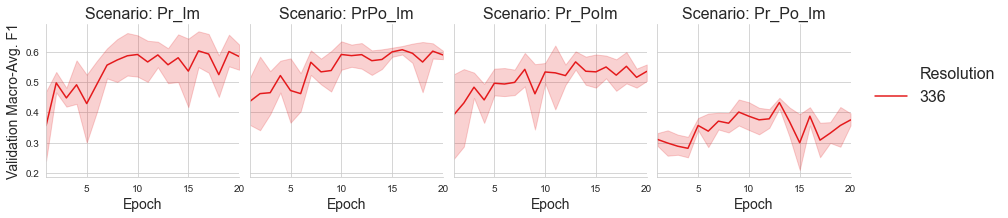

In [66]:
gg2 = plotMeanValidationMetric()

### FIGURE 7

In [72]:
def plotCNNPerformanceMetrics(performance_file, scenario="all"):
    #performance_file = "../../results/opt-cnn-performance-metrics-summary-" + str(resolution) + "px.csv"
#     resolution = performance_file.split('-')[-1].split('px')[0]
    PERFORMANCE_PLOTS = "../../figures/performance-plots/"
    resolution = performance_file.split('-')[-12].split('px')[0]
    aug_technique = performance_file.split('-')[-7].split('px')[0] + '/'
    co = ["Pr_Im", "PrPo_Im", "Pr_PoIm", "Pr_Po_Im"]
    if 'test' in performance_file:
        model_name = performance_file.split('-')[-16].split('px')[0]
    else:
        model_name = performance_file.split('-')[-14].split('px')[0]
    print(model_name)
    dfm = pd.read_csv(performance_file)
    num_epochs = dfm.epoch.max() #"accuracy", "val_accuracy",
    #melted_df = dfm.melt(id_vars = ["epoch", "Scenario"], value_vars = ["loss", "accuracy", "val_loss", "val_accuracy"], var_name = "metric", value_name = "value")
    melted_df = dfm.melt(id_vars = ["epoch", "Scenario"], value_vars = ["loss", "accuracy", "val_loss", "val_accuracy", "val_f1", "val_precision", "val_recall"], var_name = "metric", value_name = "value")
    melted_df["metric_type"] = None
    melted_df["phase"] = "Validation"
    melted_df.loc[melted_df.metric.isin(["loss", "val_loss"]), "metric_type"] = "Loss"
    melted_df.loc[melted_df.metric.isin(["accuracy", "val_accuracy", "val_f1", "val_precision", "val_recall"]), "metric_type"] = "Performance"
    melted_df.loc[melted_df.metric.isin(["loss", "accuracy"]), "phase"] = "Training"
#     if not scenario=="all":
#         melted_df = melted_df.loc[melted_df.Scenario==scenario]
    
    sns.set_style("whitegrid")
    if not scenario=="all":
        g = sns.FacetGrid(melted_df, col="Scenario", row="metric_type", sharey = False, hue_kws = {"linestyle" : ["-","--"]})
    else:
        g = sns.FacetGrid(melted_df, col="Scenario", row="metric_type", col_order = co, sharey = False, hue_kws = {"linestyle" : ["-","--"]})
    g.map_dataframe(sns.lineplot, x = "epoch", y = "value", ci=None, hue = "metric", style="phase",  style_order=["Validation", "Training"], alpha=.85,
                    #palette= sns.color_palette("Set2", n_colors=8) 
                   )
    g.set_axis_labels("Epoch", "", fontsize = 16)
    g.add_legend(bbox_to_anchor=(1.02, .75), loc=2,fontsize=16) 
    ## Customize legend
    g._legend.texts[0].set_text("")
    g._legend.texts[1].set_text("Train. loss") #Data
    g._legend.texts[2].set_text("Test loss")
    g._legend.texts[3].set_text("")    
    g._legend.texts[4].set_text("")    
    g._legend.texts[5].set_text("")    
    g._legend.texts[6].set_text("Train. accuracy")    
    g._legend.texts[7].set_text("Test accuracy")    
    g._legend.texts[8].set_text("Avg. F1")    
    g._legend.texts[9].set_text("Avg. precision")    
    g._legend.texts[10].set_text("Avg. recall")    
    g._legend.legendHandles[4].set_linewidth(0)
    g._legend.legendHandles[5].set_linewidth(0)    
    g._legend.legendHandles[6].set_linestyle('--')    
    g._legend.legendHandles[1].set_linestyle('--')         

    # g._legend._legend_box.sep = 5
    axes = g.axes
    for row, axlist in enumerate(axes):
        if row==0:
            for col, axis in enumerate(axes[row]):
                print("base model ylimit set")
                axes[row, col].set_ylim(-0.05, 5)#.75                 
                if not('base') in model_name:
                    axes[row, col].set_ylim(0, 5)
                else: 
                    pass# print("base model ylimit set")
                    #axes[row, col].set_ylim(-0.05, 4)#.75 
                if 'base' not in model_name:
                    axes[row, col].set_xlim(1, num_epochs)
                else: #'base' in model_name:
                    if num_epochs % 3 == 0:
                        majors = []
                        for i in range(1,num_epochs+1,2):
                            majors.append(i)
                        axes[row, col].xaxis.set_major_locator(tkr.FixedLocator(majors))
                    elif num_epochs % 2 == 0:
                        axes[row, col].xaxis.set_major_locator(tkr.MultipleLocator(2))
                    else:
                        majors = []
                        for i in range(1,num_epochs+1):
                            majors.append(i)
                        axes[row, col].xaxis.set_major_locator(tkr.FixedLocator(majors))
                axes[row, col].set_title("Scenario: " + str(axes[row, col].title).split("Scenario = ")[1].split(")")[0].split("\'")[0],
                                        fontsize=16)
                if col != 0:
                    axes[row, col].get_yaxis().set_ticklabels([])
                else:
                    axes[row, col].set_ylabel("Loss", fontsize=16)
        elif row==1:
            for col, axis in enumerate(axes[row]):
                #axes[row, col].set_xlim(0, 1.05)
                axes[row, col].set_ylim(0, 1.05)
                if not("base") in model_name:
                    axes[row, col].set_xlim(1, num_epochs)
                axes[row, col].set_title("")
                if col != 0:
                    axes[row, col].get_yaxis().set_ticklabels([])
                else:
                    axes[row, col].set_ylabel("Performance", fontsize=16)
    g.fig.tight_layout()
    if not os.path.exists(PERFORMANCE_PLOTS):
        os.makedirs(PERFORMANCE_PLOTS)
    subdir = os.path.join(PERFORMANCE_PLOTS, aug_technique)
    if not os.path.exists(subdir):
        os.makedirs(subdir)
    exec_instance = os.path.join(subdir,TM+'/')
    if not os.path.exists(exec_instance):
        os.makedirs(exec_instance)
    if scenario != "all":
        g.savefig(exec_instance + model_name + "-" + scenario + "-performance-metrics-" + str(resolution) + "px-plot.png", dpi=180)
    else:
        g.savefig(exec_instance + model_name + "-performance-metrics-" + str(resolution) + "px-plot.png", dpi=180)
    print(exec_instance + model_name + "-performance-metrics-" + str(resolution) + "px-plot.png")
    return(dfm)

In [69]:
summary_path = "../../results/opt-cnn-performance-metrics-summary-base-w-336-px-h-336-px-fliplr-17-May-2022-13-59-37.csv"
inception_v3 = "../../results/opt-cnn-performance-metrics-summary-inception_v3-w-336-px-h-336-px-fliplr-21-Jun-2022-23-57-23.csv"
resnet50 = "../../results/opt-cnn-performance-metrics-summary-resnet50-w-336-px-h-336-px-fliplr-21-Jun-2022-23-57-23.csv"
sota = [inception_v3, resnet50]

inception_v3
base model ylimit set
../../figures/performance-plots/fliplr/22-Jun-2022-00-21-14/inception_v3-performance-metrics-336px-plot.png
resnet50
base model ylimit set
../../figures/performance-plots/fliplr/22-Jun-2022-00-21-14/resnet50-performance-metrics-336px-plot.png


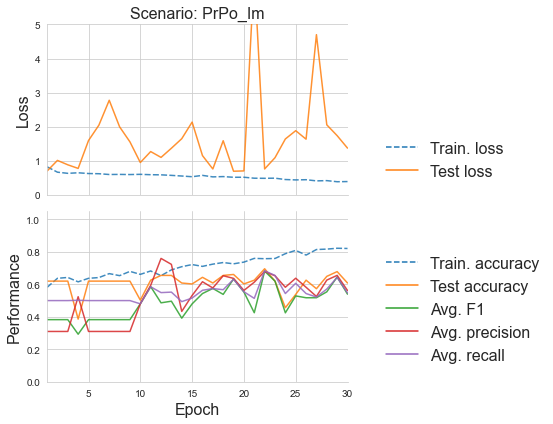

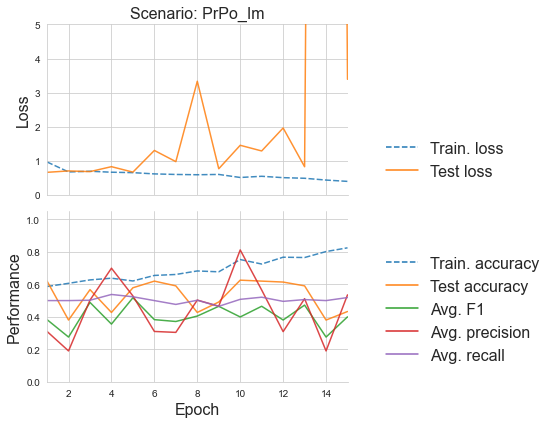

In [73]:
for model in sota:
    plotCNNPerformanceMetrics(model, scenario="PrPo_Im")

### FIGURE 6

In [24]:
dp = getPerformanceDataFrame()    

In [27]:
df = dp.loc[dp.groupby(['scenario','width','trial'])['val_accuracy'].idxmax()]

In [32]:
value_variables = ["val_accuracy", "val_f1", "val_precision", "val_recall"]
df1 = df.melt(id_vars = ['scenario','width','trial'], value_vars = value_variables,  var_name = "metric", value_name = "value")  

In [33]:
df1

,scenario,width,trial,metric,value
0,PrPo_Im,336,1,val_accuracy,0.671533
1,PrPo_Im,336,2,val_accuracy,0.635036
2,PrPo_Im,336,3,val_accuracy,0.627737
3,PrPo_Im,336,4,val_accuracy,0.684982
4,PrPo_Im,336,5,val_accuracy,0.633700
...,...,...,...,...,...
75,Pr_Po_Im,336,1,val_recall,0.435790
76,Pr_Po_Im,336,2,val_recall,0.333333
77,Pr_Po_Im,336,3,val_recall,0.382547
78,Pr_Po_Im,336,4,val_recall,0.398754


In [46]:
row_labels = ["Accuracy", "Avg. F1 score", "Avg. Precision", "Avg. Recall"]

In [45]:
def plotSummaryValidationMetrics(type="box", facet=True, metrics="performance", objective="val_accuracy"):
    dp = getPerformanceDataFrame()    
    df = dp.loc[dp.groupby(['scenario','width','trial'])[objective].idxmax()]
    num_resolutions = 4# len(dp.width.unique())
    sns.set_style("whitegrid")
    df.width = df.width.astype(object)
    if metrics=="performance":
        value_variables = ["val_accuracy", "val_f1", "val_precision", "val_recall"]
        row_labels = ["Accuracy", "Avg. F1 score", "Avg. Precision", "Avg. Recall"]
    else:
        value_variables = ["val_loss", "val_accuracy", "val_f1", "val_precision", "val_recall"]
        row_labels = ["Loss", "Accuracy", "Avg. F1 score", "Avg. Precision", "Avg. Recall"]
    #df = df[['scenario', "width", "trial", 'best_val_accuracy']].drop_duplicates()
    df = df.melt(id_vars = ['scenario','width','trial'], value_vars = value_variables,  var_name = "metric", value_name = "value")  
    df['metric'] = df['metric'].str.split("_").str[1].str.capitalize()
    # print(df['metric'])
    #df = df.melt(id_vars = ['scenario', "width", "trial"], value_vars = [metric], var_name = "metric", value_name = "value")    
    if facet==True:
        g = sns.FacetGrid(df, col="scenario", sharey = True, col_order= ["Pr_Im", "PrPo_Im", "Pr_PoIm", "Pr_Po_Im"], aspect=1) #remove 'row'
        if type=="box":
            g.map_dataframe(sns.boxplot, x = "metric", y = "value", hue = "metric",  # use metric for hue
                        palette= sns.color_palette("Set1", n_colors=num_resolutions), dodge = False,
                        showmeans=True,meanprops={"marker":"s","markerfacecolor":"white", "markeredgecolor":"gray"})#, capsize = .2, errwidth=1.2)
            g.set(ylim =(0,1))
            g.add_legend(fontsize=16, title="Metric", title_fontsize=16)#,bbox_to_anchor=(.9, .6), loc=2 )#, labels = row_labels) 
            #g._legend(title_fontsize=18)
        elif type=="point":
            g.map_dataframe(sns.pointplot, x = "metric", y = "value",  capsize = .2, errwidth=1.2)
            g.set(ylim =(.89,1.0))       
        g.set_xticklabels([])
        tick_scale = np.round(np.arange(0,1.1,0.2),2)
        g.set(yticks=tick_scale)
        g.set_yticklabels(tick_scale, fontsize=14)
        # g.set_yticklabels(g.get_ymajorticklabels(), fontsize=18)
        #g.set_axis_labels("Resolution", "Validation Accuracy")
        axes = g.axes
        for row, axlist in enumerate(axes):
            for col, axis in enumerate(axes[row]):
                if col==0:
                    axes[row,0].set_ylabel("Value", fontsize=16) #row_labels[row], fontsize=14
                    axes[row,0].set_xlabel("")
                if row==0:
                    axes[row,col].set_title("Strategy: " + str(axes[row,col].title).split("scenario = ")[1].split(")")[0].split("\'")[0], fontsize=16)
                    axes[row,col].set_xlabel("")
                else:
                    axes[row,col].set_title("")
                    # axes[row,0].set_xlabel("")
                # axes[-1, col].set_xlabel("Resolution")
                
                #Ref:https://stackoverflow.com/questions/36874697/how-to-edit-properties-of-whiskers-fliers-caps-etc-in-seaborn-boxplot
                for i,artist in enumerate(axis.artists):
                    # Set the linecolor on the artist to the facecolor, and set the facecolor to None
                    col = artist.get_facecolor()
                    artist.set_edgecolor(col)
                    artist.set_facecolor('None')

                    # Each box has 6 associated Line2D objects (to make the whiskers, fliers, etc.)
                    # Loop over them here, and use the same colour as above
                    # JO: now this is 7 because of square marker indicating mean value
                    for j in range(i*7, i*7 + 7):
                        line = axis.lines[j]
                        line.set_color(col)
                        line.set_mfc(col)
                        line.set_mec(col)

        # Also fix the legend
        g.legend.set_title('Test metric',prop={'size':16})
        for legpatch in g.legend.get_patches():
            col = legpatch.get_facecolor()
            legpatch.set_edgecolor(col)
            legpatch.set_linewidth(2)
            legpatch.set_facecolor('None')

        g.tight_layout()
        g.savefig("../../figures/scenario_resolution_performance_metrics_336_"+str(type)+"_obj_" + objective + "plot.png", dpi=180)
    elif facet==False:
        #plt.figure(figsize=(14,4))
        #ax = plt.subplot(121)
        if type=="box":
            g = sns.boxplot( x = "scenario", y = "value", hue = "width", data = df, 
                            showmeans=True,meanprops={"marker":"s","markerfacecolor":"white", "markeredgecolor":"gray"},
                            palette= sns.color_palette("Set1", n_colors=num_resolutions))#, ax=ax)
        elif type=="bar":
            g = sns.barplot( x = "scenario", y = "value", hue = "width", data = df,  ci=None, order= ["Pr_Im", "PrPo_Im", "Pr_PoIm", "Pr_Po_Im"],
                            #showmeans=True,meanprops={"marker":"s","markerfacecolor":"white", "markeredgecolor":"gray"},
                            palette= sns.color_palette("Set1", n_colors=num_resolutions))#, ax=ax)
            g.set(yticks = np.arange(0,1,.1))
        elif type=="point":
            g = sns.pointplot(x = "scenario", y = "value", hue = "width", data = df, palette= sns.color_palette("Set1", n_colors=num_resolutions), dodge=True,capsize = .2, errwidth=1.2, boxprops=dict(alpha=.3))#, ax=ax)            
        g.legend(bbox_to_anchor=(1.05, 1), loc=2, title= "Resolution",borderaxespad=0.)
        g.set(xlabel="Scenario", ylabel="Validation Accuracy")
        g.get_figure().tight_layout()
        g.get_figure().savefig("../../figures/scenario_resolution_performance_metrics_336" + type + "plot.png", dpi=180)
    return

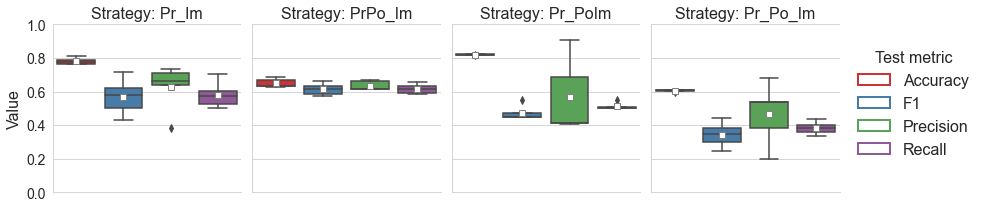

In [46]:
plotSummaryValidationMetrics()

In [202]:
dp = getPerformanceDataFrame()    
df = dp.loc[dp.groupby(['scenario','width','trial'])["val_accuracy"].idxmax()]
num_resolutions = 4# len(dp.width.unique())
sns.set_style("whitegrid")
df.width = df.width.astype(object)
# if metrics=="performance":
#     value_variables = ["val_accuracy", "val_f1", "val_precision", "val_recall"]
#     row_labels = ["Accuracy", "Avg. F1 score", "Avg. Precision", "Avg. Recall"]
# else:
#     value_variables = ["val_loss", "val_accuracy", "val_f1", "val_precision", "val_recall"]
#     row_labels = ["Loss", "Accuracy", "Avg. F1 score", "Avg. Precision", "Avg. Recall"]
#df = df[['scenario', "width", "trial", 'best_val_accuracy']].drop_duplicates()
df = df.melt(id_vars = ['scenario','width','trial'], value_vars = value_variables,  var_name = "metric", value_name = "value")  


In [203]:
df

,scenario,width,trial,metric,value
0,PrPo_Im,336,1,val_accuracy,0.671533
1,PrPo_Im,336,2,val_accuracy,0.635036
2,PrPo_Im,336,3,val_accuracy,0.627737
3,PrPo_Im,336,4,val_accuracy,0.684982
4,PrPo_Im,336,5,val_accuracy,0.633700
...,...,...,...,...,...
75,Pr_Po_Im,336,1,val_recall,0.435790
76,Pr_Po_Im,336,2,val_recall,0.333333
77,Pr_Po_Im,336,3,val_recall,0.382547
78,Pr_Po_Im,336,4,val_recall,0.398754


In [204]:
df1 = df.copy()

In [206]:
df1['metric'] = df1['metric'].str.split("_").str[1]

In [210]:
df1

,scenario,width,trial,metric,value
0,PrPo_Im,336,1,accuracy,0.671533
1,PrPo_Im,336,2,accuracy,0.635036
2,PrPo_Im,336,3,accuracy,0.627737
3,PrPo_Im,336,4,accuracy,0.684982
4,PrPo_Im,336,5,accuracy,0.633700
...,...,...,...,...,...
75,Pr_Po_Im,336,1,recall,0.435790
76,Pr_Po_Im,336,2,recall,0.333333
77,Pr_Po_Im,336,3,recall,0.382547
78,Pr_Po_Im,336,4,recall,0.398754


In [148]:
val_vars = ["val_accuracy", "val_f1", "val_precision", "val_recall"]

In [152]:
"val_accuracy".split("_")[1]
[x.split("_")[1] for x in val_vars]

['accuracy', 'f1', 'precision', 'recall']

In [89]:
num_resolutions

1